In [18]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy.interpolate import interp1d
from astropy.cosmology import Planck15 as cosmo
from astropy import constants
from xcorr import load_binary_data
from py21cmsense import GaussianBeam, Observatory, Observation, PowerSpectrum, hera
import xcorr
import pickle
import copy
import sys
import glob
from scipy.ndimage import gaussian_filter1d
import matplotlib as mpl
from powerbox import get_power

## Save 21cm Power Spectra

In [3]:
def z_to_nu(z, nu_0 = 1420.):
    """Convert redshift to frequency (by default for 21cm)
    """
    nu = nu_0 / (z + 1.)
    return nu

In [4]:
def get_redshifts(p):
    """
    Returns the redshifts of observations by pulling them directly from the files
    """
    paths = glob.glob(os.path.join(p, 'delta_T*'))
    zs = []

    for path in paths:
        fname = os.path.basename(path)
        zs.append(float(fname.split('_')[3].split('z')[1]))

    zs.sort()
    return zs

In [ ]:
zs = get_redshifts('../../data/')
zs = zs[:-2]
nu_s = z_to_nu(np.array(zs))

In [ ]:
dT_files = glob.glob('../../data/delta_T_v3_z00*')
dT_files.sort()
dT_files = dT_files[:-2]

In [ ]:
dT_files = glob.glob('../../data/delta_T_v3_z00*')
dT_files.sort()
dT_files = dT_files[:-2]
bins = 14

ps = {}

for i, f in enumerate(dT_files):
    dT = np.reshape(load_binary_data(f), (256, 256, 256))
    ps_21, k = xcorr.dimensional_ps(dT, 200, bins = bins, log_bins = True, dimensionless = True)
    ps[str(zs[i])] = ps_21

In [ ]:
ps['k'] = k
ps['zs'] = zs
ps['nu_s'] = nu_s

In [ ]:
np.savez('ps_21', **ps)

In [ ]:
lat = -30.72 * np.pi / 180.
layout_350 = np.loadtxt('../hera_positions_staged/antenna_positions_350.dat', delimiter=' ')

## Components Need for Full SNR Calculation

In [19]:
sense_files = glob.glob('21cmSense_objs/hera_sense_[!mod]*')
sense_files.sort()

In [20]:
atten = np.load('attenuation.npz')
atten.files

['zs', 'tau', 'xH']

In [21]:
ir_cubes = glob.glob('../../data/lyman_alpha_cube_*npy')
ir_cubes.sort()

diffuse_ir_cubes = glob.glob('../../data/diffuse_ir_cube*')
diffuse_ir_cubes.sort()

In [22]:
radio_cubes = glob.glob('../../data/delta*')
radio_cubes.sort()

In [45]:
c = constants.c


"""

Parallel Mode Resolution

"""

def k_par_res(z, R_res = 41.5):
    """k parallel mode resolution for SPHEREx
    """
    return 2 * np.pi * (R_res * cosmo.H(z) / (c * (1 + z))).to(u.Mpc ** -1)


"""

Perpendicular Mode Resolution

"""

def k_perp_res(z, x_pix = 6.2 * u.arcsecond):
    """Perpendicular Resolution for 
    """
    theta = x_pix.to(u.radian)
    return 2 * np.pi / (cosmo.comoving_distance(z) * theta)


"""

Window Function to Introduce Resolution Error to SPHEREx

"""

def W(kperp, kpar, z):
    """Window function to handle resolution limitations of SPHEREx
    
    Parameters
    ----------
    kperp: float
    kpar: float 
    z: float
    
    Returns:
    
    """
    kpar_res = k_par_res(z).value
    kperp_res = k_perp_res(z).value
    return np.exp((kperp / kperp_res) ** 2 + (kpar / kpar_res) ** 2)

In [7]:
def V_pix(z, x_pix = 6.2 * u.arcsecond):
    """
    """
    return ((cosmo.kpc_comoving_per_arcmin(z) * x_pix) ** 2 / k_par_res(z)).to(u.Mpc ** 3) / 2.

def lyman_noise(ps_interp, kperp, kpar, z, thermal = True, sample = True,
                thermal_noise = 3e-20):
    """
    Noise contribution from SPHEREx-like experiment
    """
    k = np.sqrt(kperp ** 2 + kpar ** 2)
    var = 0
    nu = 2.466e15 / (1. + z)
    if sample:
        try:
            var += ps_interp(k)
        except ValueError:
            return np.inf
    
    if thermal:
        var += k ** 3 / (2 * np.pi ** 2) * V_pix(z).value * (nu * thermal_noise) ** 2 * W(kperp, kpar, z)
        
    return var

def x_var(kperp, kpar, pspec):
    """
    """
    k = np.sqrt(kperp ** 2 + kpar ** 2)
    try:
        return pspec(k)
    except ValueError:
        return np.inf
    return 

def x_power_spec(ks, pspec):
    """
    """
    ps = []
    for k in ks:
        try:
            ps.append(pspec(k))
        except ValueError:
            ps.append(np.inf)
    return np.array(ps)

In [6]:
def unpickle(f):
    """Func
    """
    with open(f, 'rb') as pkl_file:
        sensitivity = pickle.load(pkl_file)
    return sensitivity

## Cross Power Spectrum and Cross-Correlation Coefficient

In [26]:
colors = plt.cm.inferno(np.linspace(0.2, 0.8, 14))
cross_ps = {}

for ind in np.arange(len(sense_files)):
    print (ind)
    z = atten['zs'][ind]
    tau = atten['tau'][ind]
    scalar = xcorr.mK_to_SB(1 * u.mK, z = z).value

    I_lya = np.load(ir_cubes[ind]) 
    I_lya *= tau # attenuation factor

    diffuse = np.load(diffuse_ir_cubes[ind])
    I_lya += diffuse

    dT = load_binary_data(radio_cubes[ind])
    dT = np.reshape(dT, (256,256,256))

    ps, k = xcorr.dimensional_ps(dT * scalar, 200, deltax2 = I_lya,  bins = 14, log_bins = True)
    cross_ps[str(k)] = ps

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [27]:
np.savez('cross_power_spectra.npz', **cross_ps)

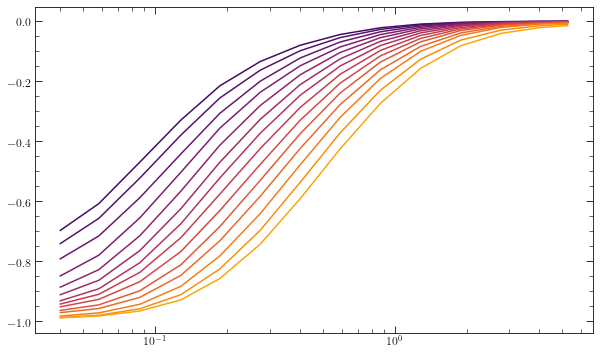

In [43]:
plt.figure(figsize = (10,6))

for i, ccc in enumerate(cccs):
    plt.plot(k, gaussian_filter1d(ccc, 1.5), color = colors[i])

plt.xscale('log')
plt.show()

In [16]:
I_lya = np.load(ir_cubes[7]) 
I_lya *= tau # attenuation factor

dT = load_binary_data(radio_cubes[7])
dT = np.reshape(dT, (256,256,256))

# Cross-Power Spectrum Calculation
xps_i, xk_i = xcorr.dimensional_ps(dT * scalar, 200, deltax2 = I_lya,  bins = 14, log_bins = True)

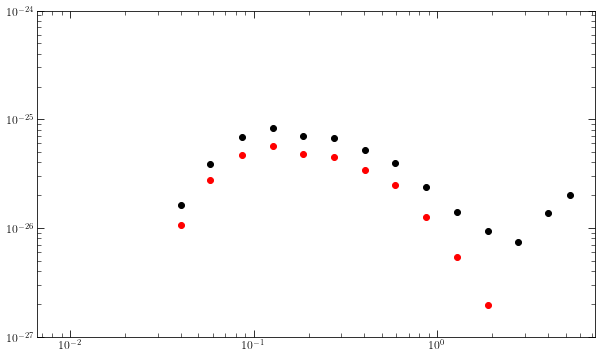

In [17]:
plt.figure(figsize = (10,6))
plt.scatter(xk, np.abs(xps), color = 'black')
plt.scatter(xk_i, np.abs(xps_i), color = 'red')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-27, 1e-24])
plt.show()

## Full Sensitivity Calculations

In [22]:
snrs = []

for ind in np.arange(len(sense_files)):
    print (ind)
    z = atten['zs'][ind]
    tau = atten['tau'][ind]
    scalar = xcorr.I_21(1 * u.mK, z = z).value
    
    I_lya = np.load(ir_cubes[ind]) 
    I_lya *= tau # attenuation factor
    
    diffuse = np.load(diffuse_ir_cubes[ind])
    I_lya += diffuse
    
    dT = load_binary_data(radio_cubes[ind])
    dT = np.reshape(dT, (256,256,256))
    
    # Cross-Power Spectrum Calculation
    xps, xk = xcorr.dimensional_ps(dT * scalar, 200, deltax2 = I_lya,  bins = 14, log_bins = True)
    xps_interp = interp1d(xk, xps)
    
    # Lya Power Spectrum Interpolation
    ps, k = xcorr.dimensional_ps(I_lya, 200, bins = 14, log_bins = True)
    ps_interp = interp1d(k, ps)
    
    # Sensitivity Calculation
    sensitivity = unpickle(sense_files[ind])
    radio_noise = sensitivity.calculate_sensitivity_2d()
    
    
    final_sense = copy.deepcopy(radio_noise)
    
    
    for i, k_perp in enumerate(radio_noise.keys()):
        for j, k_par in enumerate(sensitivity.observation.kparallel):
            # Lyman-alpha components
            lya_n = lyman_noise(ps_interp, k_perp.value, k_par.value, z = z) 
            radio_n = radio_noise[k_perp][j].value * scalar ** 2

            # Total Sensitivity
            final_sense[k_perp][j] = np.sqrt((x_var(k_perp, k_par, xps_interp) ** 2 + lya_n * radio_n) / 2.0) * u.mK ** 2 # Units: (ergs / cm^2 / sr / Hz)^2
            
    noise = sensitivity._average_sense_to_1d(final_sense)
    snrs.append(noise)
    
with open('noise_opt_w_diff_1D.pkl', 'wb') as f:
    pickle.dump(snrs, f)

0


calculating 2D sensitivity:   0%|          | 0/2590 [00:00<?, ?uv-bins/s]/usr/local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
calculating 2D sensitivity: 100%|██████████| 2590/2590 [05:23<00:00,  8.01uv-bins/s]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in exp
averaging to 1D: 100%|██████████| 1046/1046 [00:51<00:00, 20.20kpar bins/s]
/usr/local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


1


averaging to 1D: 100%|██████████| 1046/1046 [00:44<00:00, 25.16kpar bins/s]


2


averaging to 1D: 100%|██████████| 1100/1100 [00:48<00:00, 25.00kpar bins/s]


3


averaging to 1D: 100%|██████████| 1154/1154 [00:57<00:00, 25.62kpar bins/s]


4


averaging to 1D: 100%|██████████| 1209/1209 [01:01<00:00, 19.61kpar bins/s]


5


averaging to 1D: 100%|██████████| 1264/1264 [00:57<00:00, 21.86kpar bins/s]


6


averaging to 1D: 100%|██████████| 1264/1264 [03:15<00:00, 21.51kpar bins/s] 


7


averaging to 1D: 100%|██████████| 1308/1308 [01:02<00:00, 20.97kpar bins/s]


8


averaging to 1D: 100%|██████████| 1351/1351 [01:00<00:00, 22.47kpar bins/s]


9


averaging to 1D: 100%|██████████| 1394/1394 [00:59<00:00, 24.71kpar bins/s]


10


averaging to 1D: 100%|██████████| 1394/1394 [01:02<00:00, 22.21kpar bins/s]


11


averaging to 1D: 100%|██████████| 1429/1429 [01:00<00:00, 23.49kpar bins/s]


12


averaging to 1D: 100%|██████████| 1462/1462 [01:07<00:00, 20.25kpar bins/s]


13


averaging to 1D: 100%|██████████| 1463/1463 [01:05<00:00, 21.76kpar bins/s]


## 1D Power Spectra

In [27]:
cross_ps = {}

for ind in np.arange(len(sense_files)):
    print (ind)
    z = atten['zs'][ind]
    tau = atten['tau'][ind]
    scalar = xcorr.I_21(1 * u.mK, z = z).value
    
    I_lya = np.load(ir_cubes[ind]) 
    I_lya *= tau # attenuation factor
        
    dT = load_binary_data(radio_cubes[ind])
    dT = np.reshape(dT, (256,256,256))
    
    # Cross-Power Spectrum Calculation
    xps, xk = xcorr.dimensional_ps(dT * scalar, 200, deltax2 = I_lya,  bins = 14, log_bins = True)
    xk *= cosmo.h
    xps_interp = interp1d(xk, xps)
    
    sensitivity = unpickle(sense_files[ind])
    
    cross_ps[str(z)] = x_power_spec(sensitivity.k1d, xps_interp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [28]:
np.savez('cross_ps.npz', **cross_ps)

In [29]:
cross_power = np.load('cross_ps.npz')

## Noise Power Spectra

In [3]:
with open('noise_opt_w_diff_1D.pkl', 'rb') as f:
    noise_1D = pickle.load(f)

In [4]:
cross_power = np.load('cross_ps.npz')
cross_power_diff = np.load('cross_ps_w_diff.npz')

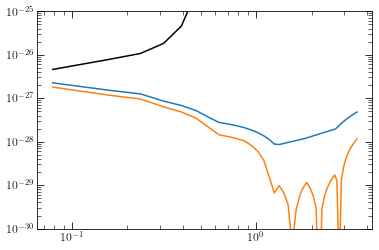

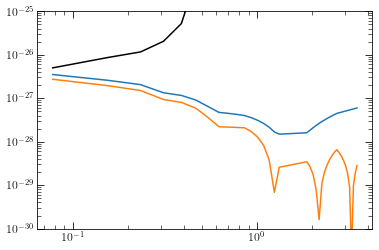

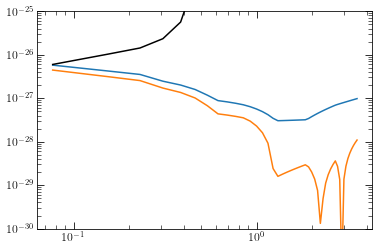

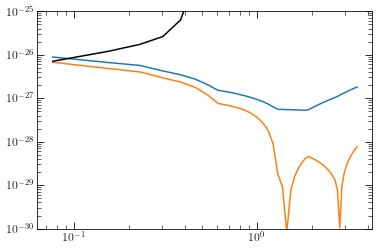

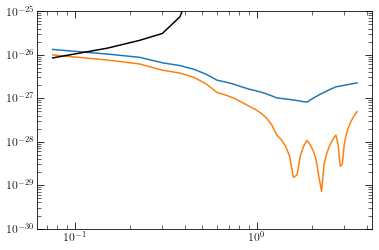

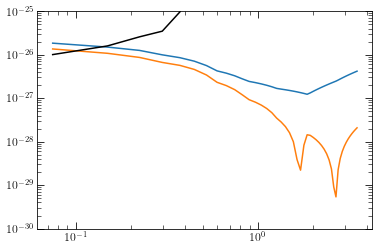

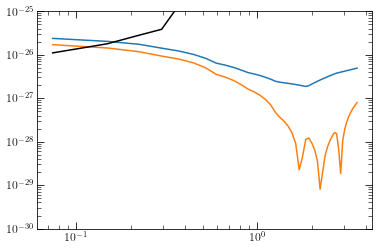

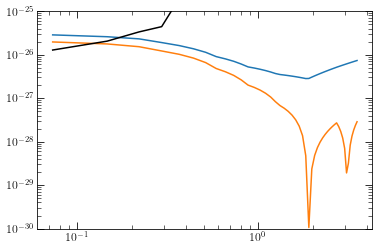

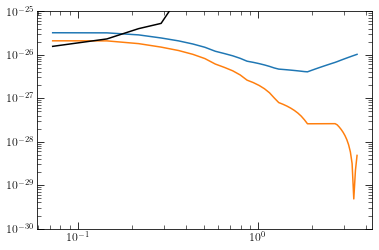

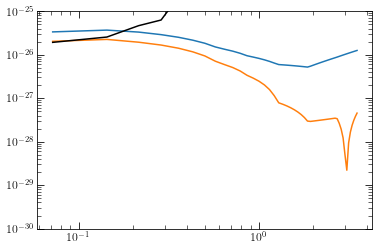

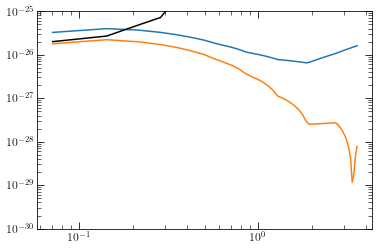

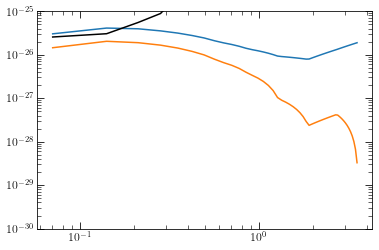

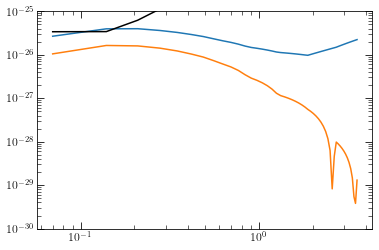

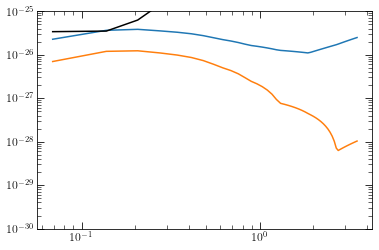

In [7]:
#plt.figure(figsize = (10, 6))

for i, x in enumerate(noise_1D):
    sensitivity = unpickle(sense_files[i])
    plt.plot(sensitivity.k1d, np.abs(cross_power_diff[cross_power_diff.files[i]]))
    plt.plot(sensitivity.k1d, np.abs(cross_power[cross_power.files[i]]))
    plt.plot(sensitivity.k1d, x, color = 'k')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([1e-30, 1e-25])
    plt.show()

In [8]:
snr = []

for i, x in enumerate(noise_1D):
    sensitivity = unpickle(sense_files[i])
    mask = np.logical_and(sensitivity.k1d >= sensitivity.k_min, sensitivity.k1d <= sensitivity.k_max)
    A = np.abs(cross_power_diff[cross_power_diff.files[i]])
    A[np.isinf(A)] = 0
    wA = A / x[mask]
    X = np.dot(wA, wA.T)
    err = np.sqrt((1.0 / np.float(X)))
    snr.append(err)


In [9]:
zs = np.array([float(i) for i in cross_power.files])
snr = np.array(snr)

In [ ]:
spherex = np.load('spherex_snr.npz')
cdim = np.load('cdim_snr.npz')

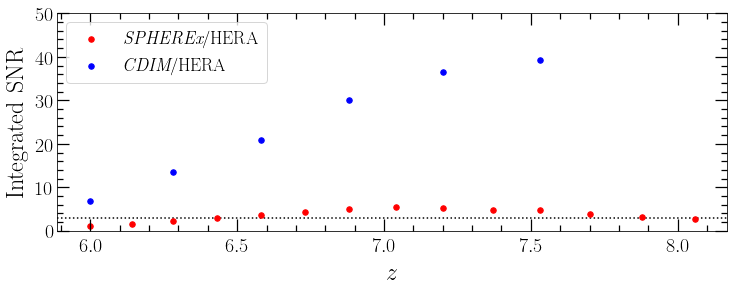

In [44]:
plt.figure(figsize = (12, 4))
plt.scatter(spherex['zs'], spherex['snr'], s = 30, color = 'red', label = r'$\textit{SPHEREx}$/HERA')
plt.scatter(cdim['zs'], cdim['snr'], s = 30, color = 'blue', label = r'$\textit{CDIM}$/HERA')
plt.xlabel('$z$', fontsize = 24, labelpad = 7)
plt.ylabel('Integrated SNR', fontsize = 24, labelpad = 7)
plt.tick_params(axis='both', which='major', labelsize=20, width = 1.25, length = 12)
plt.tick_params(axis='both', which='minor', width = 1.25, length = 6)
plt.tick_params(axis='x', pad = 7)
plt.axhline(3., color = 'k', linestyle = ':', zorder = 0)
plt.ylim([0, 50.])
plt.legend(fontsize = 18)
#plt.show()
plt.savefig('pub_plots/comparison_snr.pdf', dpi = 300, bbox_inches = 'tight')

## Cross Terms

In [73]:
ind = 7

z = atten['zs'][ind]
tau = atten['tau'][ind]
scalar = xcorr.I_21(1 * u.mK, z = z).value

I_lya = np.load(ir_cubes[ind]) 
I_lya *= tau # attenuation factor

diffuse = np.load(diffuse_ir_cubes[ind])
I_lya += diffuse

dT = load_binary_data(radio_cubes[ind])
dT = np.reshape(dT, (256,256,256))

# Cross-Power Spectrum Calculation
xps, xk = xcorr.dimensional_ps(dT * scalar, 200, deltax2 = I_lya,  bins = 14, log_bins = True)
xps_interp = interp1d(xk, xps)

# Lya Power Spectrum Interpolation
ps, k = xcorr.dimensional_ps(I_lya, 200, bins = 14, log_bins = True)
ps_interp = interp1d(k, ps)

# Sensitivity Calculation
sensitivity = unpickle(sense_files[ind])

In [74]:
therm_21 = sensitivity.calculate_sensitivity_2d(sample = False, thermal = True)
sample_21 = sensitivity.calculate_sensitivity_2d(sample = True, thermal = False)

calculating 2D sensitivity:   0%|          | 0/2444 [00:00<?, ?uv-bins/s]/usr/local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
calculating 2D sensitivity: 100%|██████████| 2444/2444 [01:27<00:00, 28.01uv-bins/s]


In [75]:
final_sense = copy.deepcopy(therm_21)
cross_terms = [copy.deepcopy(therm_21), 
               copy.deepcopy(therm_21), 
               copy.deepcopy(therm_21), 
               copy.deepcopy(therm_21)]

In [76]:
for i, k_perp in enumerate(therm_21.kdeys()):
    for j, k_par in enumerate(sensitivity.observation.kparallel):
        # Lyman-alpha components
        therm_lya = lyman_noise(ps_interp, k_perp.value, k_par.value, z = z, thermal = True, sample = False) # Units: (ergs / cm^2 / sr / Hz)^2
        sample_lya = lyman_noise(ps_interp, k_perp.value, k_par.value, z = z, thermal = False, sample = True) # Units: (ergs / cm^2 / sr / Hz)^2
        
        # Total Lyman-alpha noise
        lya_n = therm_lya + sample_lya
        radio_n = (therm_21[k_perp][j].value + sample_21[k_perp][j].value) * scalar ** 2  # Units: (ergs / cm^2 / sr / Hz)^2
                
        # Cross terms
        cross_terms[0][k_perp][j] = np.sqrt(sample_21[k_perp][j].value * sample_lya * scalar ** 2 / 2.) * u.mK **2
        cross_terms[1][k_perp][j] = np.sqrt(sample_21[k_perp][j].value * therm_lya * scalar ** 2 / 2.) * u.mK **2
        cross_terms[2][k_perp][j] = np.sqrt(sample_lya * therm_21[k_perp][j].value * scalar ** 2 / 2.) * u.mK **2
        cross_terms[3][k_perp][j] = np.sqrt(therm_lya * therm_21[k_perp][j].value * scalar ** 2 / 2.) * u.mK **2

        
        # Total Sensitivity
        final_sense[k_perp][j] = np.sqrt((x_var(k_perp, k_par, xps_interp) ** 2 + lya_n * radio_n) / 2.0) * u.mK ** 2 # Units: (ergs / cm^2 / sr / Hz)^2

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in exp


In [77]:
x_noise = sensitivity._average_sense_to_1d(final_sense)
cross_noise = [sensitivity._average_sense_to_1d(xs) for xs in cross_terms]

averaging to 1D: 100%|██████████| 1308/1308 [01:24<00:00,  6.29kpar bins/s]
/usr/local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
averaging to 1D: 100%|██████████| 1308/1308 [01:24<00:00, 15.41kpar bins/s]


In [78]:
xterm_labels = [r'$\Delta_{21} \Delta_{\rm Ly \alpha}$',
                r'$\Delta_{21} \Delta_{\rm Ly \alpha, N}$',
                r'$\Delta_{\rm Ly \alpha} \Delta_{\rm 21, N}$',
                r'$\Delta_{\rm Ly \alpha, N} \Delta_{\rm 21, N}$']

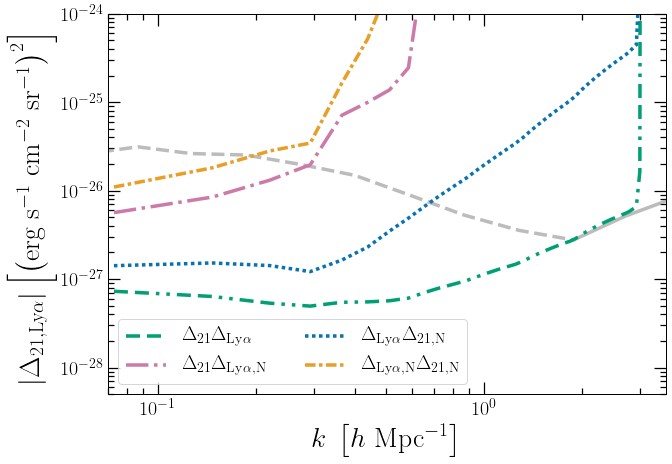

In [96]:
mpl.rcParams['axes.linewidth'] = 1

k1d = sensitivity.k1d

plt.figure(figsize = (10, 7))
plt.plot(xk[11:] * cosmo.h, np.abs(xps[11:]), color = '#7A7A7A',
    alpha = 0.5, linewidth = 3.5)
plt.plot(xk[:12] * cosmo.h, np.abs(xps[:12]), '--', color = '#7A7A7A',
    alpha = 0.5, linewidth = 3.5)

colors_e = ['red', 'green', 'purple', 'blue']
colors_e = ['#5F4690', '#CC503E', '#0F8554', '#38A6A5']
colors_e = ['#5F4690', '#CC503E', '#0F8554', '#1D6996']
colors_e = ['#00A074', '#CC7AA8', '#0773B3', '#E79F27']
linestyles = [(0, (4, 2, 4, 2, 1, 2, 1, 2)), '-.',
              (0, (1, 1)), (0, (3, 1, 1, 1))]

for i, x_t in enumerate(cross_noise):
    x_t[np.isinf(x_t)] = 1e5 * u.mK ** 2
    plt.plot(k1d, x_t, '-.', color = colors_e[i], label = xterm_labels[i], lw = 3.5, ls = linestyles[i])

#plt.plot(ks, noise, c='k', ls='-', linewidth = 2, label='Total Noise')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.07, 3.60])
plt.ylim([5e-29, 1e-24])
plt.tick_params(axis='both', which='major', labelsize=20, width = 1.25, length = 12)
plt.tick_params(axis='both', which='minor', width = 1.25, length = 6)
plt.tick_params(axis='x', pad = 7)
plt.legend(fontsize = 20, ncol=2)
plt.xlabel(r'$k \; \left[h \ {\rm Mpc}^{-1} \right]$', fontsize = 28)
plt.ylabel(r' $|\Delta_{21, \rm Ly\alpha} | \left[ \left({\rm erg \ s^{-1} \ cm^{-2} \ sr^{-1}}\right)^2\right]$', fontsize = 28)
#plt.show()
plt.savefig('pub_plots/error_budget_corrected.pdf', bbox_inches='tight', dpi = 500)

In [77]:
def AB_mag_to_Jy(mag):
    return 10 ** ((mag + 48.6) / (-2.5)) * u.erg / u.cm ** 2 / u.second / u.Hz

## Fix Plot

In [23]:
xpss = []
xks = []

for ind in [0, 7, 13]:
    z = atten['zs'][ind]
    tau = atten['tau'][ind]
    scalar = xcorr.I_21(1 * u.mK, z = z).value

    I_lya = np.load(ir_cubes[ind]) 
    I_lya *= tau # attenuation factor

    diffuse = np.load(diffuse_ir_cubes[ind])
    I_lya += diffuse

    dT = load_binary_data(radio_cubes[ind])
    dT = np.reshape(dT, (256,256,256))

    # Cross-Power Spectrum Calculation
    xps, xk = xcorr.dimensional_ps(dT * scalar, 200, deltax2 = I_lya,  bins = 14, log_bins = True)
    xpss.append(xps)
    xks.append(xk)

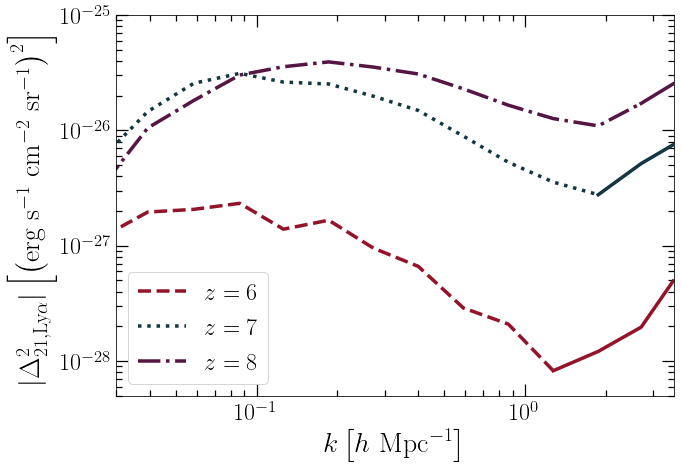

In [40]:
plt.figure(figsize = (10,7))

ls = ['--', ':', '-.']
colors = ['#941328', '#143642', '#561643']

plt.plot(xks[0][:11] * cosmo.h, np.abs(xpss[0][:11]), linestyle = ls[0], color = colors[0],
         label = r'$z = 6$', linewidth = 3.5)

plt.plot(xks[0][10:] * cosmo.h, np.abs(xpss[0][10:]), color = colors[0], linewidth = 3.5)

plt.plot(xks[0][:12] * cosmo.h, np.abs(xpss[1][:12]), linestyle = ls[1], color = colors[1],
         label = r'$z = 7$', linewidth = 3.5)
plt.plot(xks[0][11:] * cosmo.h, np.abs(xpss[1][11:]), color = colors[1], linewidth = 3.5)

plt.plot(xks[0][:13] * cosmo.h, np.abs(xpss[2][:13]), linestyle = ls[2], color = colors[2],
         label = r'$z = 8$', linewidth = 3.5)
plt.plot(xks[0][12:] * cosmo.h, np.abs(xpss[2][12:]), color = colors[2], linewidth = 3.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k \left[h \ \mathrm{Mpc}^{-1} \right]$', fontsize = 28)
plt.ylabel(r'$|\Delta^2_{21, \mathrm{Ly}\alpha} | \left[ \left({\rm erg \ s^{-1} \ cm^{-2} \ sr^{-1}}\right)^2\right]$', fontsize = 28)
plt.legend(fontsize = 24)
plt.xlim([3e-2, 3.6])
plt.ylim([5e-29, 1e-25])
plt.tick_params(axis='both', which='major', labelsize=24, width = 1.25, length = 12)
plt.tick_params(axis='both', which='minor', width = 1.25, length = 6)
plt.tick_params(axis='x', pad = 7)
#plt.show()
plt.savefig('pub_plots/cross_power_spec_fix.pdf', dpi = 500, bbox_inches = 'tight')